### IMPLEMENTING A MODIFIED ALGORIHM 

Key Modifications made :  Cutom Binarizing function ;  Different weight initialization update method ; Ability to limit the number of maximum clusters using max_clusture parameter ; analyze vigilance function  to store results  for each parameter , plot confusion matrix function to visualize confusion matrix , and accumulating them into a main function to call them at once ; also printing the clusture id's assigned during each vigilance parameter . 

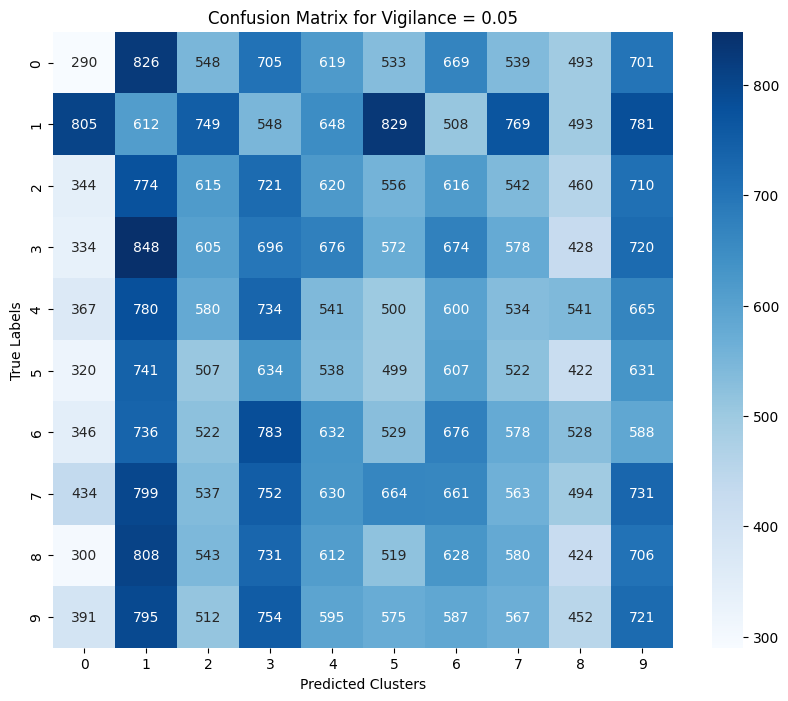

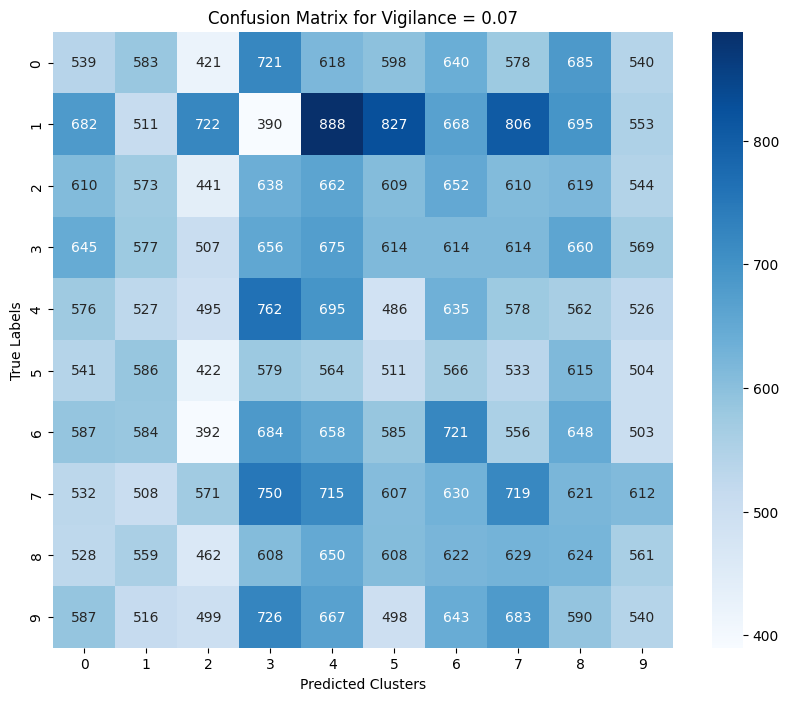

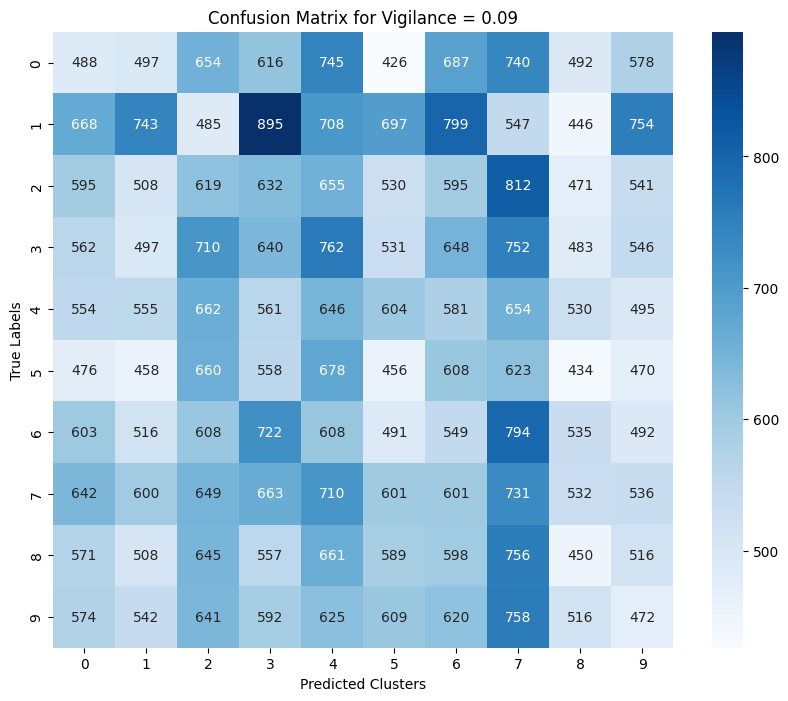

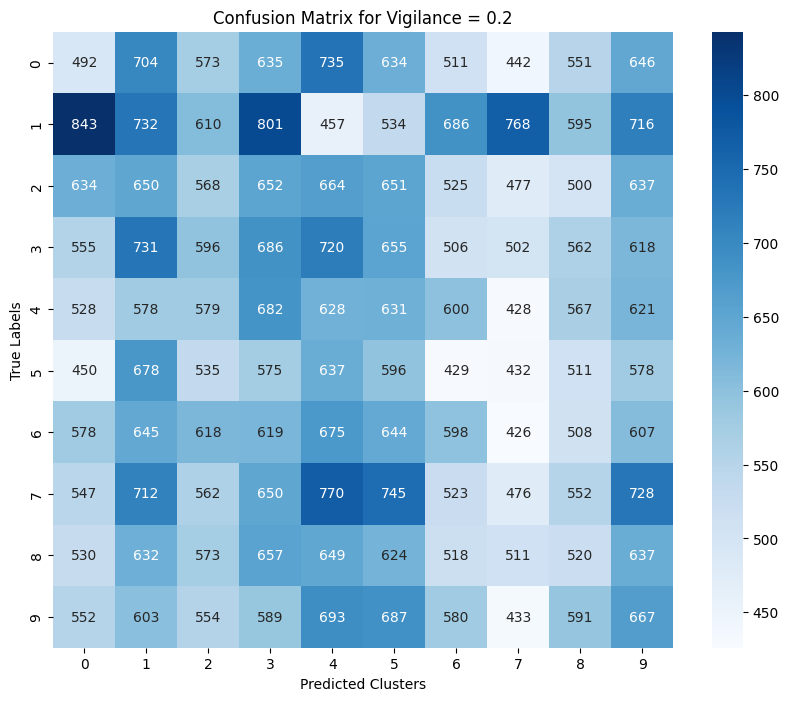

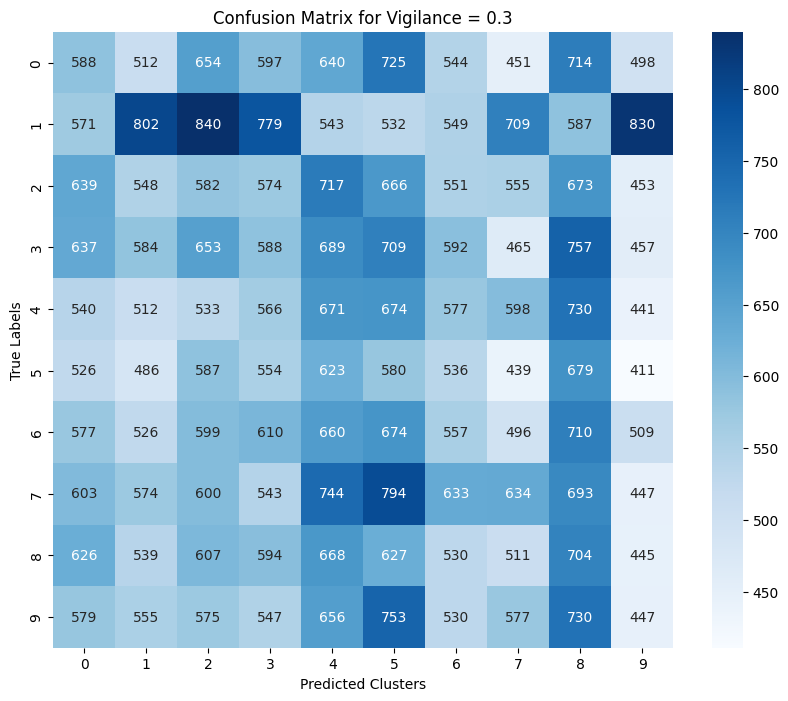

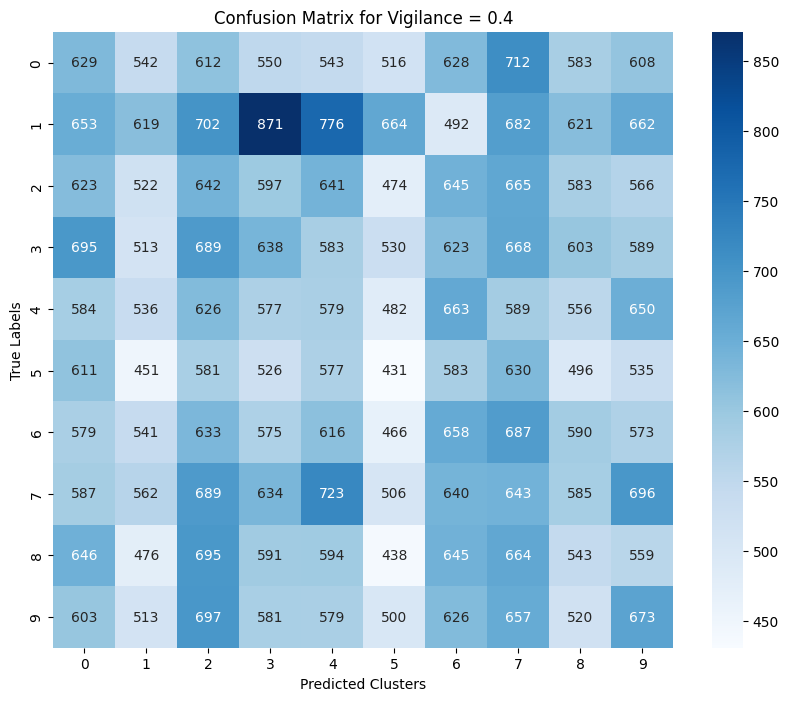

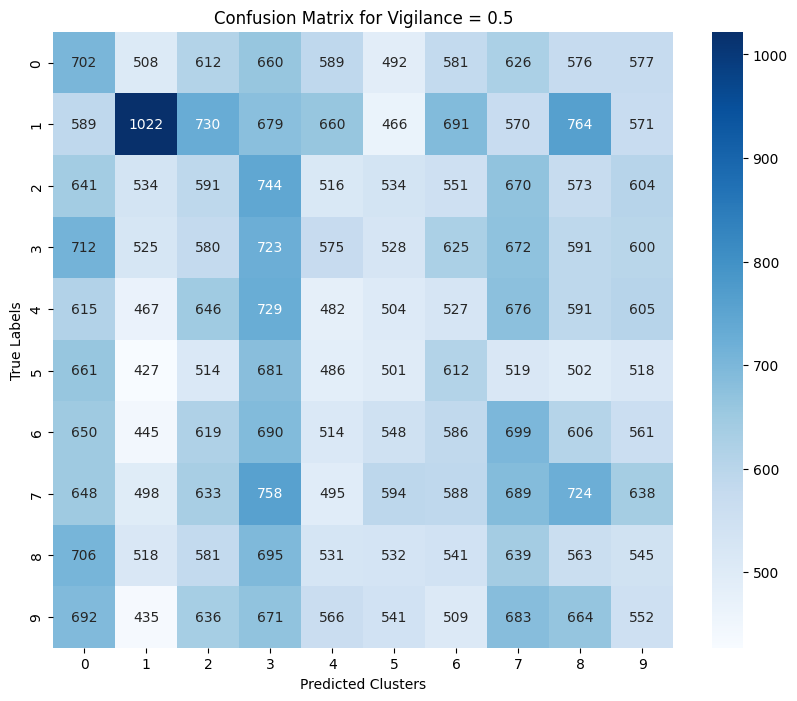

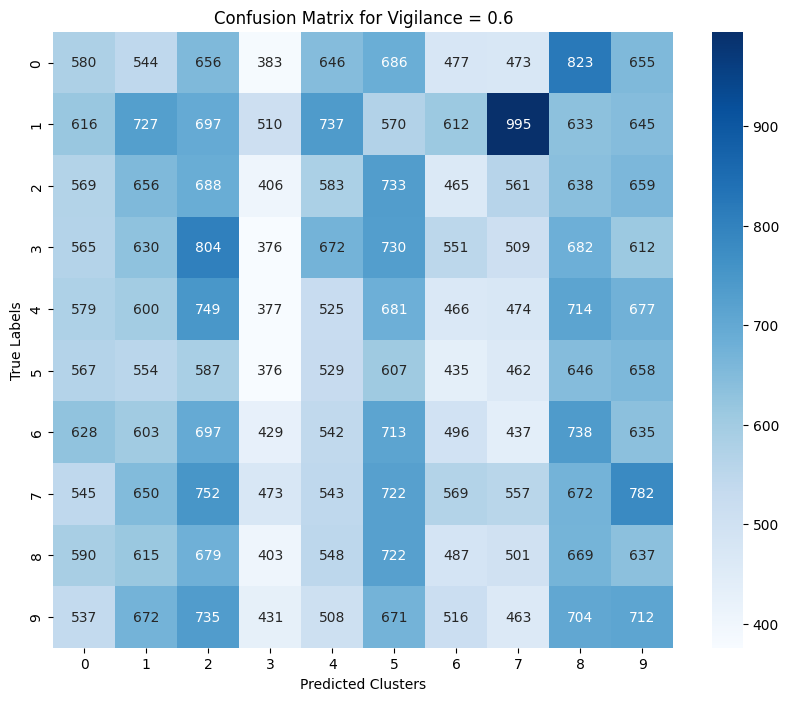

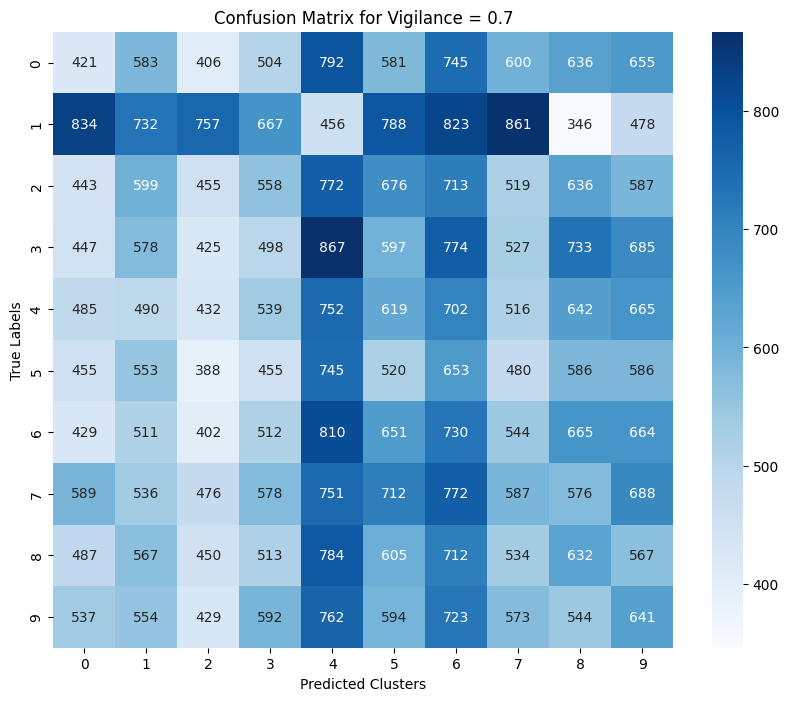

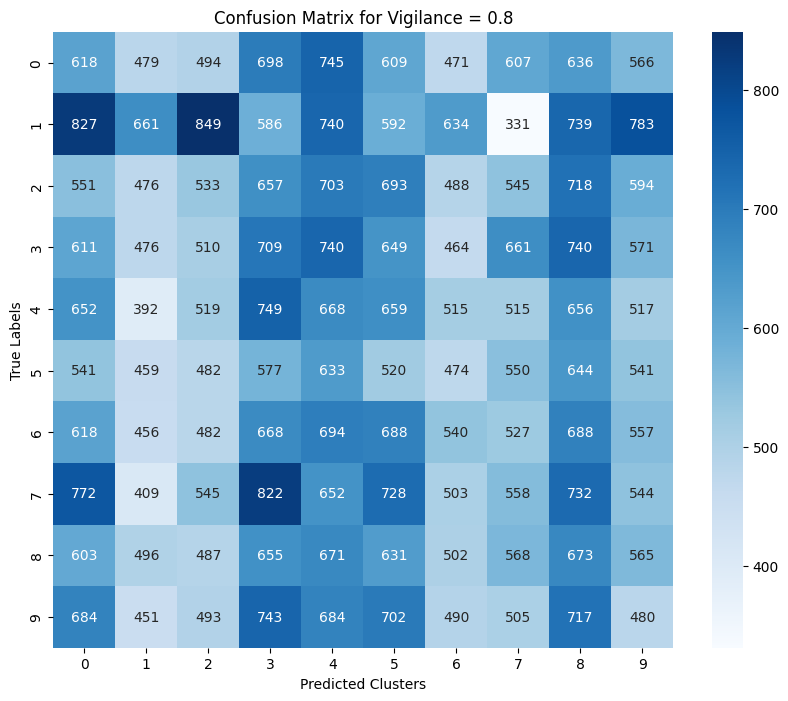

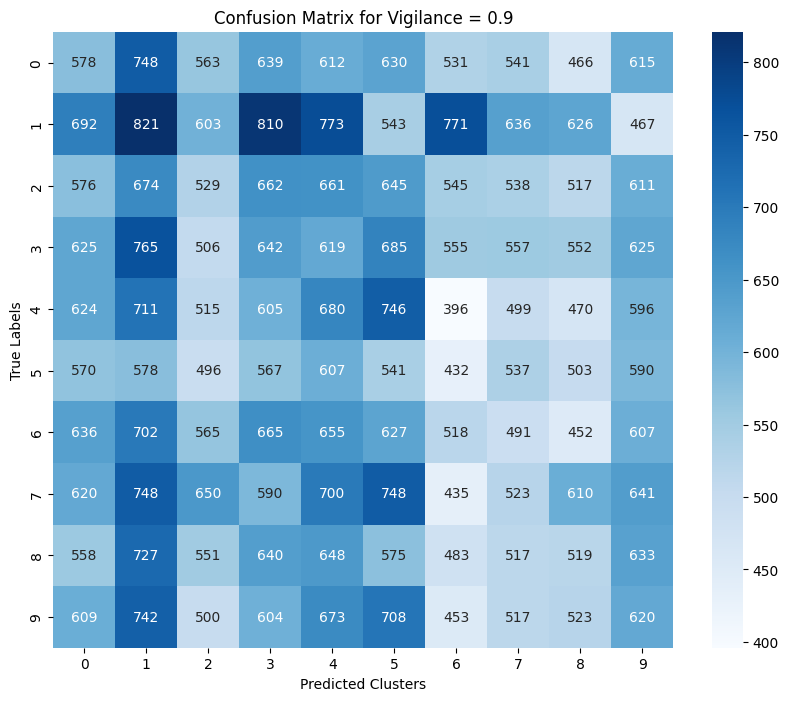

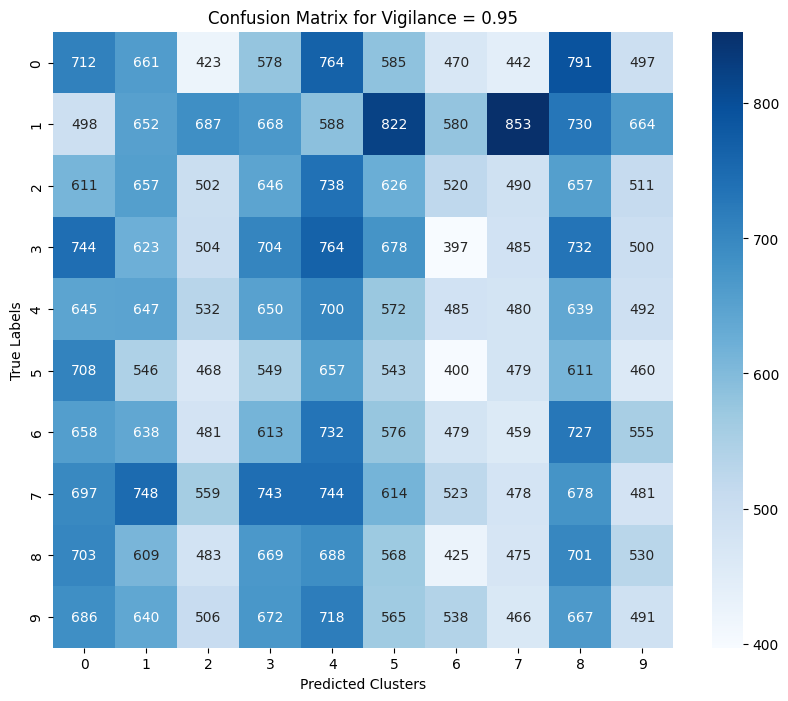

Vigilance = 0.05:
  Number of clusters: 10
  Cluster assignments: [3931 7719 5718 7058 6111 5776 6226 5772 4735 6954]

Vigilance = 0.07:
  Number of clusters: 10
  Cluster assignments: [5827 5524 4932 6514 6792 5943 6391 6306 6319 5452]

Vigilance = 0.09:
  Number of clusters: 10
  Cluster assignments: [5733 5424 6333 6436 6798 5534 6286 7167 4889 5400]

Vigilance = 0.2:
  Number of clusters: 10
  Cluster assignments: [5709 6665 5768 6546 6628 6401 5476 4895 5457 6455]

Vigilance = 0.3:
  Number of clusters: 10
  Cluster assignments: [5886 5638 6230 5952 6611 6734 5599 5435 6977 4938]

Vigilance = 0.4:
  Number of clusters: 10
  Cluster assignments: [6210 5275 6566 6140 6211 5007 6203 6597 5680 6111]

Vigilance = 0.5:
  Number of clusters: 10
  Cluster assignments: [6616 5379 6142 7030 5414 5240 5811 6443 6154 5771]

Vigilance = 0.6:
  Number of clusters: 10
  Cluster assignments: [5776 6251 7044 4164 5833 6835 5074 5432 6919 6672]

Vigilance = 0.7:
  Number of clusters: 10
  Cluster a

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def load_and_binarize_mnist(threshold=0.5):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train / 255.0).reshape(-1, 28*28)
    x_test = (x_test / 255.0).reshape(-1, 28*28)
    x_train_bin = (x_train > threshold).astype(int)
    x_test_bin = (x_test > threshold).astype(int)
    return x_train_bin, y_train, x_test_bin, y_test

def initialize_weights(num_features, max_clusters): 
    return np.random.rand(max_clusters, num_features)  

def train_art1(x_train, vigilance, max_clusters): 
    num_samples, num_features = x_train.shape
    weights = initialize_weights(num_features, max_clusters)
    clusters = np.zeros(num_samples, dtype=int)

    for i in range(num_samples):
        input_vector = x_train[i]
        similarities = np.dot(weights, input_vector)
        j = np.argmax(similarities)

        if np.dot(weights[j], input_vector) / np.linalg.norm(weights[j]) >= vigilance:
            weights[j] = (weights[j] + input_vector) / 2.0
            clusters[i] = j
        else:
            if len(weights) < max_clusters:
                new_cluster = len(weights)
                weights = np.vstack([weights, input_vector])
                clusters[i] = new_cluster
            else:
                # Find the least-populated cluster
                least_populated_cluster = np.argmin(np.bincount(clusters))
                weights[least_populated_cluster] = (weights[least_populated_cluster] + input_vector) / 2.0
                clusters[i] = least_populated_cluster

    return weights, clusters

def analyze_vigilance(x_train, y_train, vigilance_values, max_clusters):
    results = {}
    for v in vigilance_values:
        weights, clusters = train_art1(x_train, v, max_clusters)
        results[v] = {"weights": weights, "clusters": clusters}
        plot_confusion_matrix(y_train, clusters, v)
    return results

def plot_confusion_matrix(y_true, y_pred, vigilance_value):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_pred))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Clusters')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Vigilance = {vigilance_value}')
    plt.show()

def main():
    # Load and binarize MNIST dataset
    x_train_bin, y_train, x_test_bin, y_test = load_and_binarize_mnist()

    # Analyze the effect of different vigilance values and plot confusion matrices
    vigilance_values = [0.05,0.07,0.09, 0.2, 0.3, 0.4,  0.5, 0.6,  0.7, 0.8, 0.9, 0.95]
    results = analyze_vigilance(x_train_bin, y_train, vigilance_values, max_clusters=10)

    # Print the results
    for v, result in results.items():
        print(f"Vigilance = {v}:")
        print(f"  Number of clusters: {len(np.unique(result['clusters']))}")
        print(f"  Cluster assignments: {np.bincount(result['clusters'])}")
        print()

if __name__ == "__main__":
    main()

### IMPLEMENTATION FROM SCRATCH

## Approach -1 Using psuedocode from class, additional approach to utilize learning rate in the algorithm 

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix

class ART1:
    def __init__(self, n, vigilance, learning_rate=0.5):
        self.n = n
        self.vigilance = vigilance
        self.learning_rate = learning_rate
        self.weights = []
        self.nodes = []

    def _initialize_weights(self):
        return np.ones(self.n) / (self.n + 1)

    def _compute_similarity(self, s, x):
        return np.dot(s, x) / (np.linalg.norm(s) * np.linalg.norm(x))

    def learn(self, x):
        if not self.nodes:
            self.weights.append(self._initialize_weights())
            self.nodes.append(x)
            return

        similarities = [self._compute_similarity(w, x) for w in self.weights]
        best_match_index = np.argmax(similarities)
        best_match_similarity = similarities[best_match_index]

        if best_match_similarity >= self.vigilance:
            self.weights[best_match_index] = (1 - self.learning_rate) * self.weights[best_match_index] + self.learning_rate * x
        else:
            self.weights.append(self._initialize_weights())
            self.nodes.append(x)

    def classify(self, x):
        similarities = [self._compute_similarity(w, x) for w in self.weights]
        best_match_index = np.argmax(similarities)
        best_match_similarity = similarities[best_match_index]

        if best_match_similarity >= self.vigilance:
            return best_match_index
        else:
            return -1

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


#a subset of 8,000 samples
subset_size = 8000
X_train_subset = X_train[:int(subset_size*0.8)]  # 6,400 samples for training
y_train_subset = y_train[:int(subset_size*0.8)]
X_test_subset = X_train[int(subset_size*0.8):int(subset_size)]  # 1,600 samples for testing
y_test_subset = y_train[int(subset_size*0.8):int(subset_size)]

# Binarize images (convert to black and white)
X_train_binary = (X_train_subset > 127).astype(int).reshape(-1, 784)
X_test_binary = (X_test_subset > 127).astype(int).reshape(-1, 784)

# Define vigilance values to experiment with
vigilance_values = [0.09, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9]

# Experiment with each vigilance value
for vigilance in vigilance_values:
    art1 = ART1(n=784, vigilance=vigilance)

    # Train the network on the training data
    for x in X_train_binary:
        art1.learn(x)

    # Classify the test data
    predictions = []
    for x in X_test_binary:
        classification = art1.classify(x)
        predictions.append(classification)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_subset, predictions)

    # Print the results
    print(f"Vigilance: {vigilance:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print()

Vigilance: 0.09
Confusion Matrix:
[[167   0   0   0   0   0   0   0   0   0]
 [188   0   0   0   0   0   0   0   0   0]
 [164   0   0   0   0   0   0   0   0   0]
 [161   0   0   0   0   0   0   0   0   0]
 [139   0   0   0   0   0   0   0   0   0]
 [150   0   0   0   0   0   0   0   0   0]
 [153   0   0   0   0   0   0   0   0   0]
 [160   0   0   0   0   0   0   0   0   0]
 [166   0   0   0   0   0   0   0   0   0]
 [152   0   0   0   0   0   0   0   0   0]]

Vigilance: 0.10
Confusion Matrix:
[[167   0   0   0   0   0   0   0   0   0]
 [188   0   0   0   0   0   0   0   0   0]
 [164   0   0   0   0   0   0   0   0   0]
 [161   0   0   0   0   0   0   0   0   0]
 [139   0   0   0   0   0   0   0   0   0]
 [150   0   0   0   0   0   0   0   0   0]
 [153   0   0   0   0   0   0   0   0   0]
 [160   0   0   0   0   0   0   0   0   0]
 [166   0   0   0   0   0   0   0   0   0]
 [152   0   0   0   0   0   0   0   0   0]]

Vigilance: 0.30
Confusion Matrix:
[[  2   0   0   3  47   5   4 104 

### Alternative Scratch Implementation [Runtime for this algorithm is high; Expected: around 2 - 2.5 hours ]

## Highlighted my work on the algorithm using the comments  "my implementation" 

In [1]:
import numpy as np  #my implementation
import matplotlib.pyplot as plt #my implementation
from sklearn.datasets import fetch_openml   #my implementation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay    #my implementation
from sklearn.model_selection import train_test_split       #my implementation
from random import randint
from multiprocessing import Pool, cpu_count, current_process    #my implementation

# Load MNIST dataset 
mnist = fetch_openml('mnist_784', version=1) #my implementation
data = mnist['data'].to_numpy() #my implementation
labels = mnist['target'].astype(int).to_numpy()  #my implenentation

# Binarize images with a reasonable threshold
threshold = 127         #my implementation

def binarize_images(images, threshold, shape=(28, 28)):
    binarized = (images > threshold).astype(int)  #my implementation
    return binarized.reshape(-1, *shape)  #my implementation

binarized_images = binarize_images(data, threshold)

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    binarized_images, labels, test_size=0.2, random_state=42)  #my implementation

class Art1:
    def _countOnes(self, Instance):
        return np.sum(Instance == 1.0)  #my implementation

    def _countCommonOnes(self, Instance1, Instance2):
        assert Instance1.shape == Instance2.shape      #my implementation
        return np.sum((Instance1 == 1.0) & (Instance2 == 1.0)) #my implementation

    def _addInstanceBin(self, Instance, PrototypeI):
        self.Prototypes[PrototypeI] = np.where(Instance == 0, 0, self.Prototypes[PrototypeI])  #my implementation

    def _bestPrototypeBin(self, Instance, Prototypes, Used, Beta):
        if len(Used) == len(Prototypes):
            return []
        Scores = [-1.0] * len(Prototypes)
        for i in range(len(Prototypes)):
            if any(np.array_equal(Prototypes[i], used) for used in Used):  #my implementation
                continue
            Scores[i] = self._countCommonOnes(Prototypes[i], Instance) / (Beta + self._countOnes(Prototypes[i])) #my implementation
        Higher = max(Scores)  #my implementation
        sameScores = [Prototypes[i] for i in range(len(Prototypes)) if Scores[i] == Higher] #my implementation
        if not sameScores:     
            return []
        return sameScores[randint(0, len(sameScores)-1)]      #my implementation

    def _instanceInSequence(self, PrototypesSequence, InstanceI):
        for i in range(len(PrototypesSequence)):
            if InstanceI in PrototypesSequence[i]:
                return i
        return -1

    def _removeInstance(self, Sample, InstanceI, PrototypeI):
        self.PrototypesSequence[PrototypeI].remove(InstanceI)  #my implementation
        if not self.PrototypesSequence[PrototypeI]:
            del self.Prototypes[PrototypeI]
            del self.PrototypesSequence[PrototypeI]
        else:
            self.Prototypes[PrototypeI] = Sample[self.PrototypesSequence[PrototypeI][0]].copy() #my implementation
            for i in self.PrototypesSequence[PrototypeI][1:]:
                self._addInstanceBin(Sample[i], PrototypeI)

    def _findItem(self, Samples, Instance, MustFind):
        for i in range(len(Samples)):
            if np.array_equal(Samples[i], Instance):  #my implementation
                return i
        if MustFind:
            raise ValueError(f"Instance {Instance} not found in samples.")
        return -1

    def _createCluster(self, Sample, InstanceI):
        prot_number = self._instanceInSequence(self.PrototypesSequence, InstanceI)
        if prot_number != -1:
            self._removeInstance(Sample, InstanceI, prot_number)
        self.Prototypes.append(Sample[InstanceI])
        self.PrototypesSequence.append([InstanceI])

    def doArt(self, Samples, Parameters):
        self.Prototypes = []
        self.PrototypesSequence = []
        Used = []
        Fluctuation = 100.0
        FluctuationBest = 120.0
        Pass = 0
        process_name = current_process().name  #my implementation
        while Pass < Parameters.PassNumber and Fluctuation > Parameters.Error:
            Changed = [False] * len(Samples)
            for SampleI in range(len(Samples)):
                Used = []
                if SampleI % 1000 == 0: #my implementation
                    print(f"{process_name} - Processing row {SampleI} of {len(Samples)}")  #my implementation
                while True:
                    P = self._bestPrototypeBin(Samples[SampleI], self.Prototypes, Used, Parameters.Beta)
                    if not len(P):  #my implementation
                        PrototypeIndex = self._instanceInSequence(self.PrototypesSequence, SampleI)
                        if PrototypeIndex != -1:
                            self._removeInstance(Samples, SampleI, PrototypeIndex)
                        self._createCluster(Samples, SampleI)
                        Changed[SampleI] = True
                        break
                    Used.append(P)
                    Measure1 = self._countCommonOnes(P, Samples[SampleI]) / (Parameters.Beta + self._countOnes(P))  #my implementation
                    Measure2 = self._countOnes(Samples[SampleI]) / (Parameters.Beta + len(Samples[SampleI]))  #my implementation
                    if Measure1 >= Measure2:
                        Similarity = self._countCommonOnes(P, Samples[SampleI]) / self._countOnes(Samples[SampleI]) if self._countOnes(Samples[SampleI]) > 0 else 0.0  #my implementation
                        if Similarity >= Parameters.Vigilance:
                            PrototypeIndex = self._instanceInSequence(self.PrototypesSequence, SampleI)
                            if PrototypeIndex != -1:
                                if np.array_equal(self.Prototypes[PrototypeIndex], P):  #my implementation
                                    break
                                else:
                                    self._removeInstance(Samples, SampleI, PrototypeIndex)
                            PrototypeIndex = self._findItem(self.Prototypes, P, True)
                            self._addInstanceBin(Samples[SampleI], PrototypeIndex)
                            self.PrototypesSequence[PrototypeIndex].append(SampleI)
                            Changed[SampleI] = True
                            break
                        else:
                            continue
                    else:
                        PrototypeIndex = self._instanceInSequence(self.PrototypesSequence, SampleI)
                        if PrototypeIndex != -1:
                            self._removeInstance(Samples, SampleI, PrototypeIndex)
                        self._createCluster(Samples, SampleI)
                        Changed[SampleI] = True
                        break
                    if len(self.Prototypes) != len(Samples):
                        break
            number_changed = sum(Changed) #my implementation
            Fluctuation = (number_changed / len(Samples)) * 100.0
            Pass += 1
            print(f"{process_name} - Pass: {Pass}, Fluctuation: {Fluctuation}%, clusters: {len(self.Prototypes)}")  #my implementation
            if Fluctuation < FluctuationBest:
                PrototypesBest = self.Prototypes
                PrototypesSequenceBest = self.PrototypesSequence
                FluctuationBest = Fluctuation

class Parameters:
    def __init__(self, PassNumber=10, Error=1.0, Beta=1.0, Vigilance=0.75):
        self.PassNumber = PassNumber
        self.Error = Error
        self.Beta = Beta
        self.Vigilance = Vigilance

def train_art1(train_images, params):
    art1 = Art1()
    art1.doArt(train_images, params)
    return art1

def predict_clusters(art1, test_images, params):
    predictions = []
    process_name = current_process().name  #my implementation
    for idx, image in enumerate(test_images):
        if idx % 1000 == 0:  #my implementation
            print(f"{process_name} - Predicting row {idx} of {len(test_images)}") #my implementation
        P = art1._bestPrototypeBin(image, art1.Prototypes, [], params.Beta)
        if len(P) == 0:
            predictions.append(-1) #my implementation
        else:
            predictions.append(art1._findItem(art1.Prototypes, P, True))
    return predictions

# Initialize ART1 with given parameters and vigilance values
vigilance_values = [0.5, 0.6, 0.7, 0.8, 0.9]  #my implementation
results = {}      #my implementation

def process_vigilance_value(rho):
    params = Parameters(Vigilance=rho)  #my implementation
    art1 = train_art1(train_images, params) #my implementation
    predictions = predict_clusters(art1, test_images, params)#my implementation
    cm = confusion_matrix(test_labels, predictions, labels=np.unique(predictions)) #my implementation
    return rho, {                      #my implementation
        "predictions": predictions,    #my implementation
        "confusion_matrix": cm,        #my implementation
        "num_clusters": len(np.unique(predictions))     #my implementation
    }

if __name__ == "__main__":
    with Pool(cpu_count()) as pool:  #my implementation
        results_list = pool.map(process_vigilance_value, vigilance_values)  #my implementation

    results = dict(results_list) #my implementation

    for rho, result in results.items(): #my implementation
        disp = ConfusionMatrixDisplay(confusion_matrix=result["confusion_matrix"], display_labels=np.unique(test_labels))  #my implementation
        disp.plot() #my implementation
        plt.title(f'Confusion Matrix (Vigilance: {rho})')  #my implementation
        plt.show()  #my implementation